# Exercise: Algorithm Chain

**Gunakan dataset 'adult.csv'**

Carilah model dan hyperparameter terbaik untuk memprediksi biaya asuransi tiap individu berdasarkan karakteristiknya.

1. Lakukan preprocessing pada features jika dibutuhkan.
2. Lakukan modeling dengan menggunakan logistic regression, knn, dan decision tree.<br>
    Kandidat algoritma:
    - logreg = LogisticRegression(solver='liblinear', random_state=0)
    - knn = KNeighborsClassifier(n_neighbors=5)
    - tree = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=1, max_depth=5, random_state=0)
3. Pilih 1 model terbaik berdasarkan hasil cross validasi 3 model di atas.
4. Lakukan hyperparameter tuning pada model terpilih tsb.
5. Lakukan prediksi pada test set dari model benchmark (sebelum hyperparameter tuning).
6. Lakukan prediksi pada test set dari model dengan hyperparameter tuning.
7. Bandingkan hasil performa model sebelum dan sesudah tuning.

## Import libraries

In [68]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import train_test_split

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler, MinMaxScaler

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

## Data

In [48]:
df_adult = pd.read_csv('adult.csv')
df_adult

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [35]:
# ganti missing value dgn np.nan
df_adult.replace('?',np.nan,inplace = True)

In [36]:
df_adult.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

## Preprocessing

In [37]:
# binary_encoder_pipeline = Pipeline([
#                                     ('imputer',SimpleImputer(strategy = 'constant',fill_value = 'NC')),
#                                     ('binary encoder',ce.BinaryEncoder())
# ])

# transformer = ColumnTransformer([
#                                  ('one hot encoder',OneHotEncoder(drop = 'first'),['relationship','race','sex']),
#                                  ('binary encoder',binary_encoder_pipeline,['workclass','marital.status','occupation','native.country'])
#                                 ], remainder = 'passthrough')

In [38]:
# onehot encoding
onehot = OneHotEncoder(drop = 'first')
onehot_var = ['relationship','race','sex']

# binary encoding
binary = ce.BinaryEncoder()
binary_var = ['workclass','marital.status','occupation','native.country']
binary_encoder_pipeline = Pipeline([
                                    ('imputer',SimpleImputer(strategy = 'constant',fill_value = 'Others')),
                                    ('binary encoder',binary)
])


# transformer
transformer = ColumnTransformer([       
                                 ('one hot encoder', onehot, onehot_var),
                                 ('binary encoder',binary_encoder_pipeline, binary_var)
                                ], remainder = 'passthrough')

# scaler
scaler = RobustScaler()

## Data Splitting

In [39]:
X = df_adult.drop(columns = ['fnlwgt','income','education']) 
y = np.where(df_adult['income']=='>50K', 1, 0)

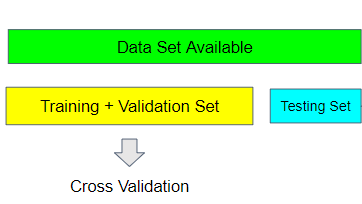

In [40]:
# data splitting
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify = y, 
    test_size=0.2,
    random_state = 0)

## Model Evaluation: Benchmark  

In [41]:
# kandidat model
logreg = LogisticRegression(solver='liblinear', random_state=0)
knn = KNeighborsClassifier(n_neighbors=5)
tree = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=1, max_depth=5, random_state=0)

In [42]:
# kandidat model
models = [logreg, knn, tree]

cv_mean = []
cv_std = []

# looping mencari model terbaik
for i in models:

    # define fold
    fold = StratifiedKFold(n_splits=5)

    # Pipeline (berisi tahapan dari preprocesing sampai modeling)
    model_pipe = Pipeline([
        ('transformer', transformer),
        ('scaler', scaler),
        ('model', i)
    ])

    # cross validation
    model_cv = cross_val_score(
        model_pipe,
        X_train,
        y_train,
        scoring='f1'
    )

    print(model_cv, i)

    cv_mean.append(model_cv.mean())
    cv_std.append(model_cv.std())

[0.63859649 0.65161576 0.65141319 0.64085447 0.63848525] LogisticRegression(random_state=0, solver='liblinear')
[0.67519604 0.69059406 0.69025812 0.67502089 0.68355482] KNeighborsClassifier()
[0.62417994 0.60819828 0.62488219 0.6221374  0.60123869] DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)


In [43]:
# Membandingkan model terbaik
pd.DataFrame({
    'model': models,
    'f1 score mean': cv_mean,
    'f1 score std': cv_std
})

,model,f1 score mean,f1 score std
0,"LogisticRegression(random_state=0, solver='lib...",0.644193,0.006038
1,KNeighborsClassifier(),0.682925,0.006859
2,"DecisionTreeClassifier(criterion='entropy', ma...",0.616127,0.009614


Benchmark Model terpilih: KNN, karena f1 score paling besar, dan model cukup stabil

## Hyperparameter Tuning

tadi kita sudah dapat model terbaik, sekarang kita laukan hyperparameter tuning terhadap KNN

In [50]:
list(range(3,30,2))

[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

In [51]:
# hyperparameter yang akan diisikan pada model (tree)
hyperparam_space = {
    'model__n_neighbors': list(range(3,30,2)),
    'model__weights' : ['uniform', 'distance'],                    
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()]
} 

In [53]:
# model benchmark
knn = KNeighborsClassifier()

# model dalam pipeline
knn_pipeline = Pipeline([
    ('transformer', transformer),
    ('scaler', scaler),
    ('model', knn)
])


# Grid search (mencari hyperparameter terbaik)
grid_search = GridSearchCV(
    estimator = knn_pipeline,            # model to tune
    param_grid = hyperparam_space,       # hyperparam space
    cv = 5,
    scoring = 'f1', # metric
    n_jobs= -1
) 

# fit grid_search pada train set
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot '
                                                                         'encoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['relationship',
                                                                          'race',
                                                                          'sex']),
                                                                        ('binary '
                                                                         'encoder',
                                                                         Pi

In [54]:
# score terbaik hasil dari grid_search
print('Best score: ', grid_search.best_score_)

# hyperparameter pada score terbaik hasil dari grid_search
print('Best param: ', grid_search.best_params_)

Best score:  0.6975522566715211
Best param:  {'model__n_neighbors': 19, 'model__weights': 'uniform', 'scaler': RobustScaler()}


In [55]:
# hasil dari 90 kombinasi hyperparameter
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_neighbors,param_model__weights,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.117118,0.056589,77.733218,20.200152,3,uniform,StandardScaler(),"{'model__n_neighbors': 3, 'model__weights': 'u...",0.601093,0.610141,0.608881,0.609176,0.609375,0.607733,0.003346,66
1,1.514593,0.350843,35.457611,1.678529,3,uniform,MinMaxScaler(),"{'model__n_neighbors': 3, 'model__weights': 'u...",0.600251,0.597849,0.605071,0.597503,0.600082,0.600151,0.002703,81
2,1.500967,0.308284,29.696212,2.504320,3,uniform,RobustScaler(),"{'model__n_neighbors': 3, 'model__weights': 'u...",0.672013,0.669691,0.687629,0.668882,0.669115,0.673466,0.007168,25
3,1.131041,0.153887,26.950564,0.746057,3,distance,StandardScaler(),"{'model__n_neighbors': 3, 'model__weights': 'd...",0.591608,0.608696,0.596624,0.601785,0.597222,0.599187,0.005745,82
4,1.052280,0.047107,24.004912,0.196167,3,distance,MinMaxScaler(),"{'model__n_neighbors': 3, 'model__weights': 'd...",0.587164,0.593830,0.587985,0.586563,0.584666,0.588042,0.003094,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.643641,0.050765,16.270628,0.186826,29,uniform,MinMaxScaler(),"{'model__n_neighbors': 29, 'model__weights': '...",0.615250,0.625110,0.614414,0.603825,0.613486,0.614417,0.006754,48
80,0.859342,0.068462,14.859661,0.217604,29,uniform,RobustScaler(),"{'model__n_neighbors': 29, 'model__weights': '...",0.689451,0.700042,0.703656,0.691613,0.676166,0.692186,0.009568,9
81,0.691892,0.056276,14.447970,0.566579,29,distance,StandardScaler(),"{'model__n_neighbors': 29, 'model__weights': '...",0.599826,0.611436,0.610564,0.590683,0.615385,0.605579,0.009059,73
82,0.639731,0.025756,14.985142,0.144828,29,distance,MinMaxScaler(),"{'model__n_neighbors': 29, 'model__weights': '...",0.602263,0.613074,0.604484,0.599730,0.612945,0.606499,0.005525,69


In [56]:
# model dengan score tertinggi
pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_neighbors,param_model__weights,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
50,0.895986,0.055833,16.127462,0.328774,19,uniform,RobustScaler(),"{'model__n_neighbors': 19, 'model__weights': '...",0.700669,0.702703,0.704408,0.696513,0.683469,0.697552,0.007519,1
56,1.032191,0.167175,15.728092,0.617232,21,uniform,RobustScaler(),"{'model__n_neighbors': 21, 'model__weights': '...",0.702003,0.704142,0.704152,0.696290,0.678068,0.696931,0.009860,2
68,0.865549,0.089663,15.496336,0.271578,25,uniform,RobustScaler(),"{'model__n_neighbors': 25, 'model__weights': '...",0.701887,0.700508,0.703688,0.697414,0.676433,0.695986,0.009990,3
62,0.856397,0.047080,15.381415,0.096260,23,uniform,RobustScaler(),"{'model__n_neighbors': 23, 'model__weights': '...",0.699540,0.700254,0.704712,0.696213,0.676420,0.695428,0.009883,4
44,0.966549,0.145863,14.749275,0.323940,17,uniform,RobustScaler(),"{'model__n_neighbors': 17, 'model__weights': '...",0.700334,0.699407,0.701120,0.689983,0.679628,0.694094,0.008279,5


## Model Performance in Test Set
Sekarang kita predict model pada Test set dan lihat hasil performanya

**Before Hyperparameter Tuning**

In [72]:
# model benchmark
knn_pipeline = Pipeline([
    ('preprocess', transformer),
    ('scaler', scaler),
    ('model', knn)
])

# fitting
knn_pipeline.fit(X_train, y_train)

# predict
y_pred = knn_pipeline.predict(X_test)

In [73]:
# Metric evaluation
f1score_before = f1_score(y_test, y_pred)
print('f1 score:', f1score_before)


f1 score: 0.6882726361510191


In [74]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      4945
           1       0.72      0.66      0.69      1568

    accuracy                           0.86      6513
   macro avg       0.81      0.79      0.80      6513
weighted avg       0.85      0.86      0.85      6513



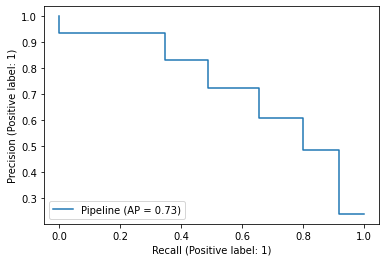

In [75]:
plot_precision_recall_curve(knn_pipeline, X_test, y_test)

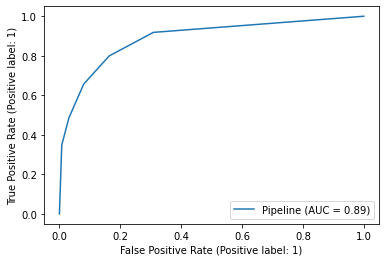

In [76]:
plot_roc_curve(knn_pipeline, X_test, y_test)

**After Hyperparameter Tuning**

In [77]:
# final model
model_final = grid_search.best_estimator_

# fitting
model_final.fit(X_train, y_train)

# predict
y_pred = model_final.predict(X_test)

In [78]:
# Metric evaluation
f1score_after = f1_score(y_test, y_pred)
print('f1 score:', f1score_after)

f1 score: 0.6934604904632152


In [79]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4945
           1       0.74      0.65      0.69      1568

    accuracy                           0.86      6513
   macro avg       0.82      0.79      0.80      6513
weighted avg       0.86      0.86      0.86      6513



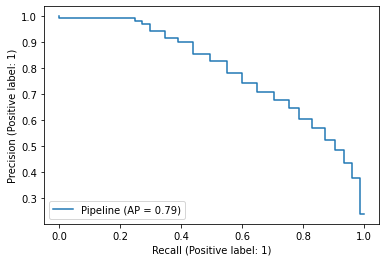

In [82]:
plot_precision_recall_curve(model_final, X_test, y_test)

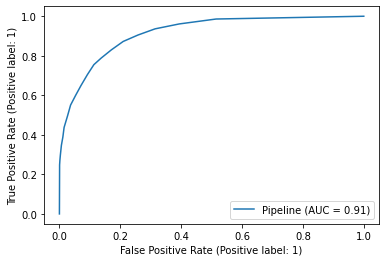

In [83]:
plot_roc_curve(model_final, X_test, y_test)